In [4]:
import pandas as pd
import numpy as np


data = pd.read_csv('../dataset/regularite-mensuelle-tgv-aqst.csv')
df = pd.DataFrame(data)


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8154 entries, 0 to 8153
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  8154 non-null   object 
 1   service                               8154 non-null   object 
 2   gare_depart                           8154 non-null   object 
 3   gare_arrivee                          8154 non-null   object 
 4   duree_moyenne                         8154 non-null   int64  
 5   nb_train_prevu                        8154 non-null   int64  
 6   nb_annulation                         8154 non-null   int64  
 7   commentaire_annulation                0 non-null      float64
 8   nb_train_depart_retard                8154 non-null   int64  
 9   retard_moyen_depart                   8154 non-null   float64
 10  retard_moyen_tous_trains_depart       8154 non-null   float64
 11  commentaire_retar

In [5]:

#On supprime les colonnes commentaires
#Potentiellement pas une bonne idée. Il faudrait d'abord supprimer les instances ayant un commentaire (cf case d'en dessous)

#df.drop(columns=['commentaire_annulation', 'commentaire_retards_depart', 'commentaires_retard_arrivee'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8154 entries, 0 to 8153
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  8154 non-null   object 
 1   service                               8154 non-null   object 
 2   gare_depart                           8154 non-null   object 
 3   gare_arrivee                          8154 non-null   object 
 4   duree_moyenne                         8154 non-null   int64  
 5   nb_train_prevu                        8154 non-null   int64  
 6   nb_annulation                         8154 non-null   int64  
 7   commentaire_annulation                0 non-null      float64
 8   nb_train_depart_retard                8154 non-null   int64  
 9   retard_moyen_depart                   8154 non-null   float64
 10  retard_moyen_tous_trains_depart       8154 non-null   float64
 11  commentaire_retar

En lisant les commentaires pour les retards à l'arrivée, on se rend compte qu'ils viennent expliquer de potentiels retards plus importants que la normale dus à des évènements extraordinaires. 

Faut-il supprimer ces instances qui viennent polluer le dataset avec des évènements complètements imprévisibles ? Si oui, il faut d'abord supprimer les lignes avant de supprimer les 

Si je comprends bien, le retard_moyen, c'est le retard moyen des trains en retard et le retard_moyen_tous_trains, c'est le retard moyen de tous les trains, c'est à dire en incluant les trains qui ne sont pas en retard dans la balance. 

On peut donc diviser le problème en deux : soit on détermine le retard moyen de tous les trains sur un mois, soit on détermine le retard moyen attendu de tous les trains en retard sur un mois. 

Finalement il faut choisir si notre modèle prédit le retard d'un train à l'arrivée, au départ sachant qu'il y a un retard, au départ sans rien savoir, à l'arrivée en sachant qu'il y a un retard à l'arrivée, sachant qu'il y a un retard au départ en connaissant ou non la durée de ce retard. 

Pour la suite de l'analyse des données, on va s'intéresser au retard moyen tous trains confondus (ceux n'ayant pas de retard également).

Première proposition pour prédire ces retards : on met en entrée les 6 premières features :  date, service, gare départ et arrivée, durée du trajet et nombre de trains prévus. 

Commençons par un comparaison entre deux lignes éloignées géographiquement, nous enchainerons ensuite par une comparaison entre deux lignes proches 
ie qui passent par les mêmes secteurs 

Pour chaque mois de 2018, on met les retards_moyens_tous_trains les uns à cotes des autres pour deux lignes

On veut voir si ce qui importe plus pour le retard c'est la ligne ou le moment de l'année et s'il y a une répétitivité dans le temps (des mois qui sont chaque année problématiques par exemple comme les mois d'hiver)

On veut vérifier s'il faut potentiellement créer une nouvelle caractéristique secteur (par exemple nord pour tous les tgvs qui prennent la ligne qui va 
vers le nord). ie ce qui compte le plus c'est pas la ligne mais les voies empruntées. 



In [6]:
#On prend deux lignes éloignées avec des temps de trajet comparables pour commencer : Paris est - strasbourg, paris nord - dunkerque

#Récupérons les instances qui correspondent à ces lignes

# Mettre en minuscule et supprimer les espaces dans la colonne
df['gare_depart'] = df['gare_depart'].str.lower()  # Mettre en minuscule
df['gare_arrivee'] = df['gare_arrivee'].str.lower()  # Mettre en minuscule
df['gare_depart'] = df['gare_depart'].str.replace(' ', '')  # Supprimer les espaces 
df['gare_arrivee'] = df['gare_arrivee'].str.replace(' ', '')  # Supprimer les espaces 

paris_stras = df[(df['gare_depart']== 'parisest') & (df['gare_arrivee'] == "strasbourg")]
paris_dunk = df[(df['gare_depart']== 'parisnord') & (df['gare_arrivee'] == "dunkerque")]


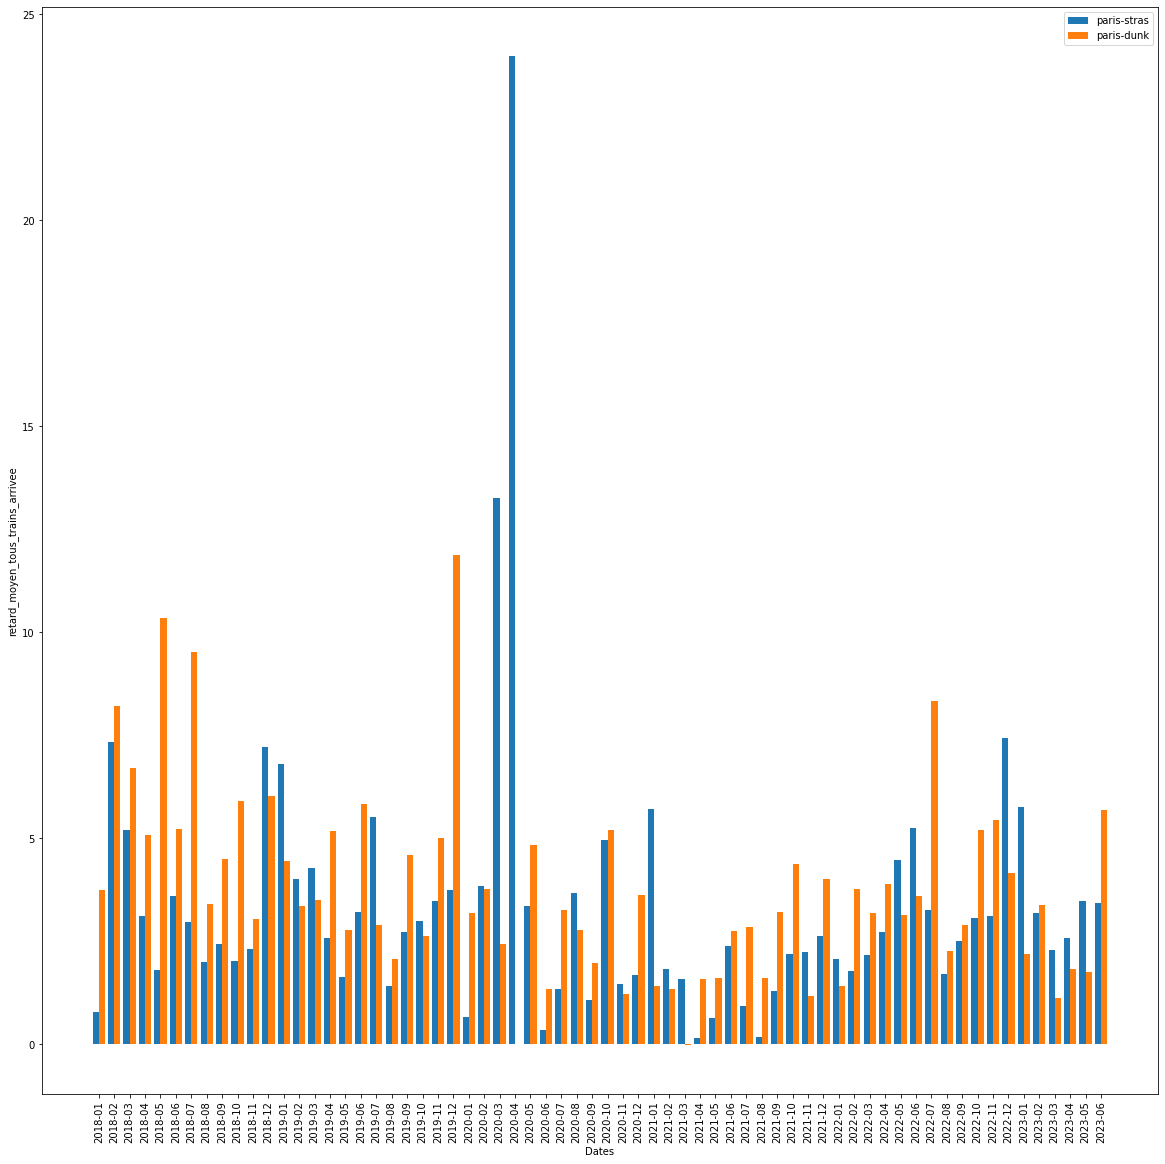

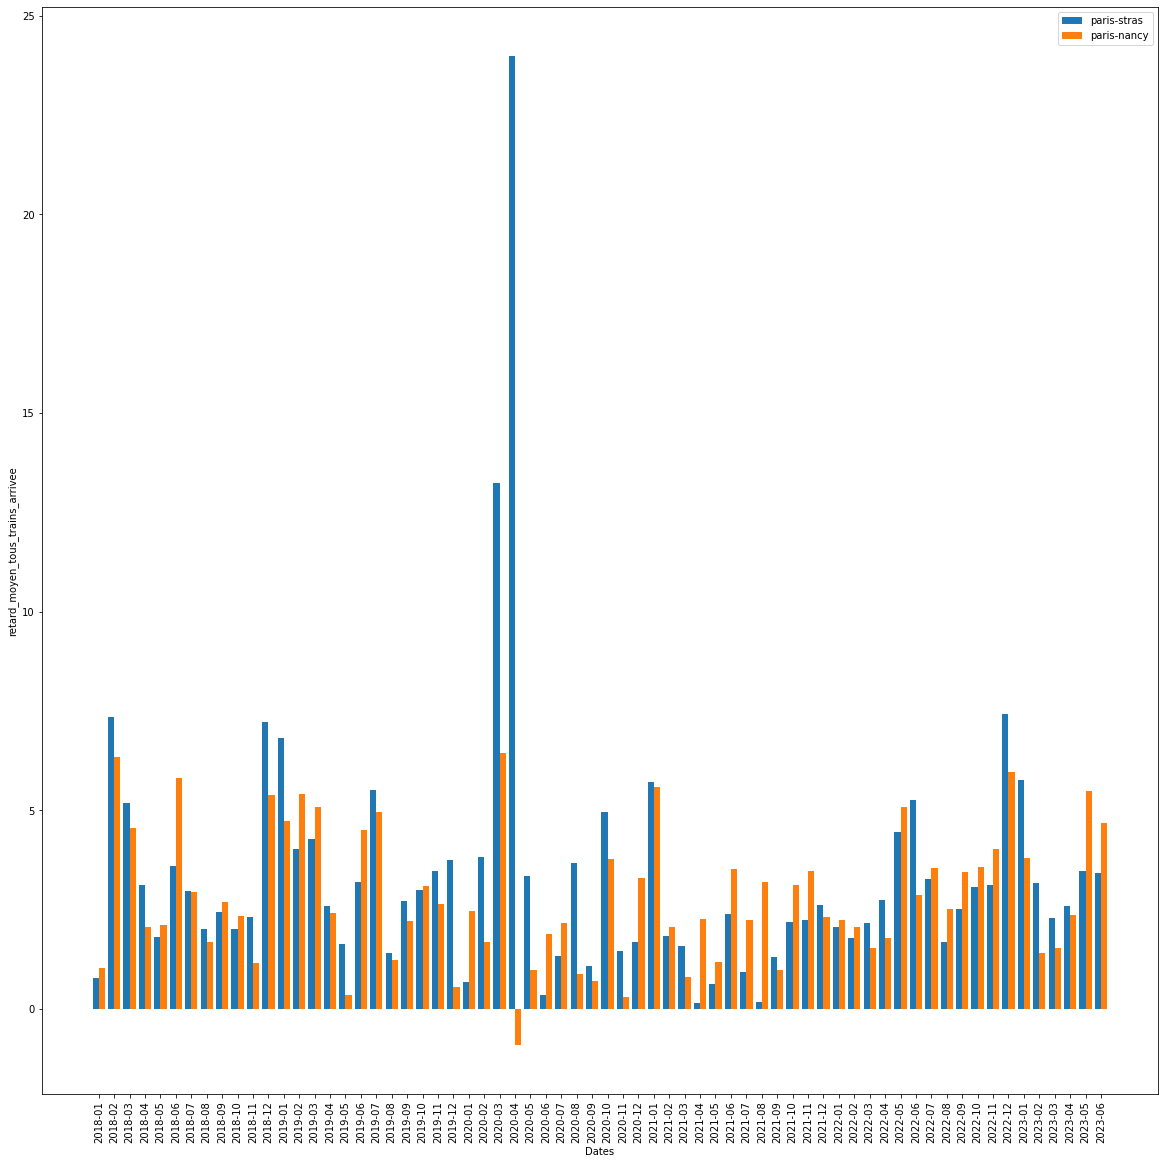

In [7]:
import matplotlib.pyplot as plt


plt.figure(figsize=(20, 20))
# Créez un graphique à barres alternant entre les catégories
largeur_barre = 0.4
indices = range(len(paris_stras))
plt.bar(indices, paris_stras['retard_moyen_tous_trains_arrivee'], width=largeur_barre, label='paris-stras', align='center')
plt.bar([i + largeur_barre for i in indices], paris_dunk['retard_moyen_tous_trains_arrivee'], width=largeur_barre, label='paris-dunk', align='center')


# Ajoutez des étiquettes d'axe et une légende
plt.xlabel('Dates')
plt.ylabel('retard_moyen_tous_trains_arrivee')
plt.xticks([i + largeur_barre / 2 for i in indices], paris_stras['date'].unique(),  rotation='vertical')
plt.legend()

plt.show()

#Comparons avec deux lignes très proches géographiquement paris stras et paris nancy
paris_nancy = df[(df['gare_depart']== 'parisest') & (df['gare_arrivee'] == "nancy")] 

plt.figure(figsize=(20, 20))
# Créez un graphique à barres alternant entre les catégories
largeur_barre = 0.4
indices = range(len(paris_stras))
plt.bar(indices, paris_stras['retard_moyen_tous_trains_arrivee'], width=largeur_barre, label='paris-stras', align='center')
plt.bar([i + largeur_barre for i in indices], paris_nancy['retard_moyen_tous_trains_arrivee'], width=largeur_barre, label='paris-nancy', align='center')


# Ajoutez des étiquettes d'axe et une légende
plt.xlabel('Dates')
plt.ylabel('retard_moyen_tous_trains_arrivee')
plt.xticks([i + largeur_barre / 2 for i in indices], paris_stras['date'].unique(),  rotation='vertical')
plt.legend()

plt.show()




On remarque que les lignes passant sur les mêmes voies ont des retards plus corrélés, ce qui parait cohérent. On pourrait donc penser à ajouter un feature voie ou secteur.

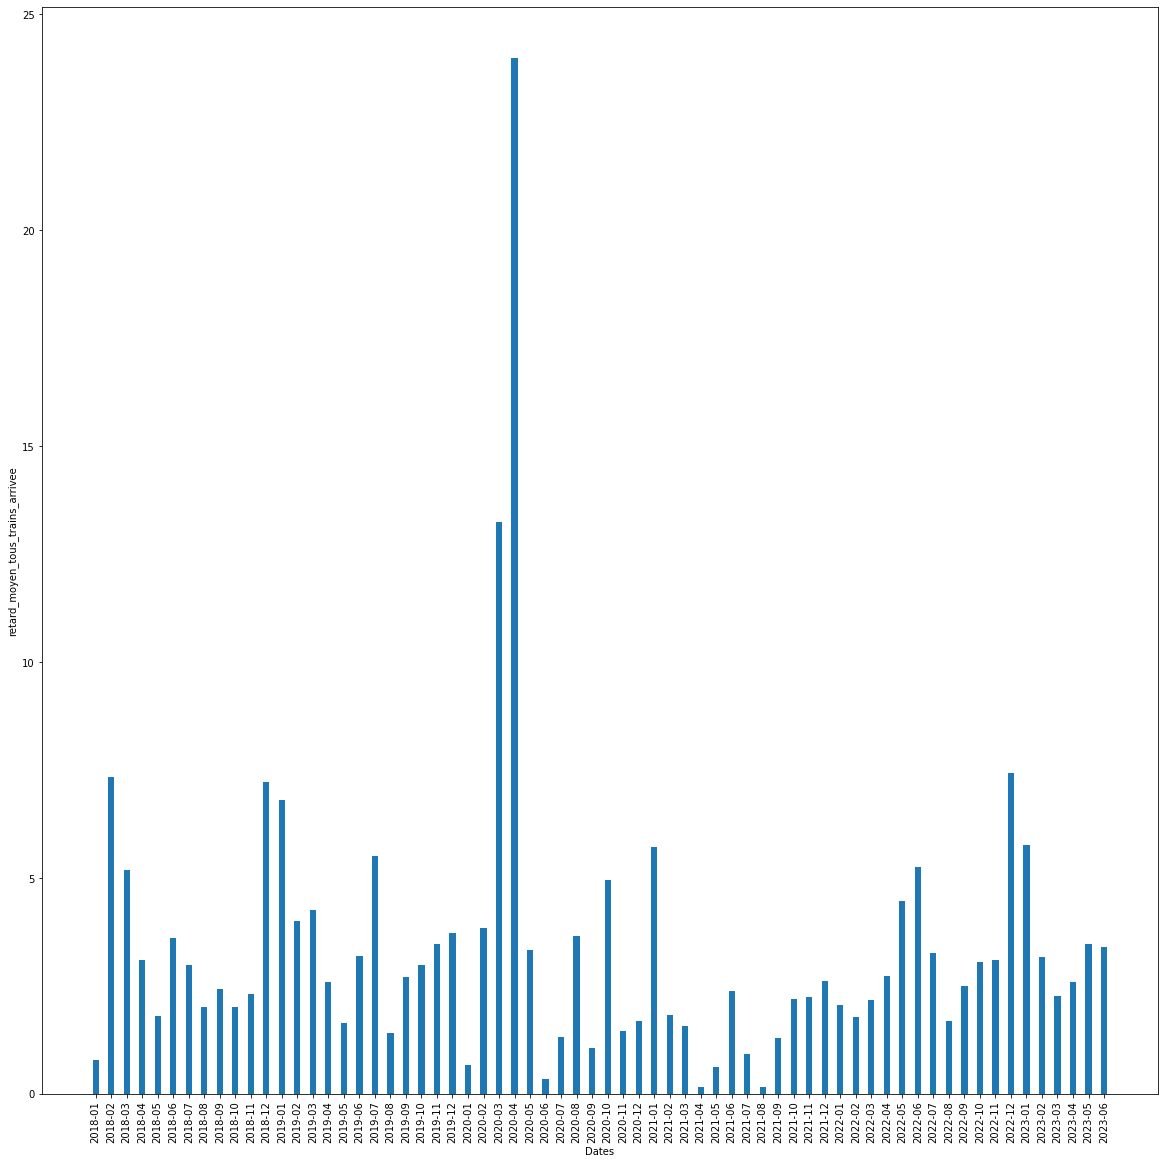

In [8]:
#On peut voir s'il y a une saisonalité des retards également, par exemple pendant les mois d'hiver ou d'été, il pourrait y avoir plus de retards. 

plt.figure(figsize=(20, 20))

plt.bar(paris_stras['date'], paris_stras['retard_moyen_tous_trains_arrivee'], width=largeur_barre, label='paris-stras', align='center')

plt.xlabel('Dates')
plt.ylabel('retard_moyen_tous_trains_arrivee')
plt.xticks(paris_stras['date'].unique(),  rotation='vertical')

plt.show()

On voit pas trop s'il y a une saisonalité. On peut récupérer la moyenne des retards pour chaque mois par exemple. 

{1: 2.07066666666667, 2: 1.77882395382395, 3: 2.16781170483461, 4: 2.7266043613707205, 5: 4.462417713943751, 6: 5.25635470826113, 7: 3.2610035211267503, 8: 1.69080161476355, 9: 2.5031141868512403, 10: 3.06567819879185, 11: 3.1111303344867403, 12: 7.421072796934861}


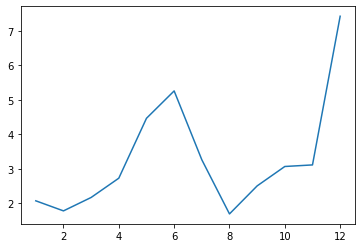

In [9]:
#On calcule les moyennes des retards par mois

moyenne_retards_par_mois = {}


annee = 2018
while annee < 2023 :
    for j in range(1,13):
        
            if  j < 10:
                moyenne_retards_par_mois[j] = paris_stras[paris_stras['date'] == str(annee) +'-0'+ str(j)]['retard_moyen_tous_trains_arrivee'].mean()
            else :
                moyenne_retards_par_mois[j] = paris_stras[paris_stras['date'] == str(annee) +'-'+ str(j)]['retard_moyen_tous_trains_arrivee'].mean()

    annee+=1

print(moyenne_retards_par_mois)

plt.plot(moyenne_retards_par_mois.keys(), moyenne_retards_par_mois.values())

plt.show()


On remarque que les informations sur le mois on l'air de plus compter que l'information sur l'année. Vérifions dans un plot ci-dessous.

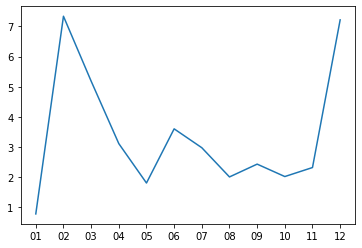

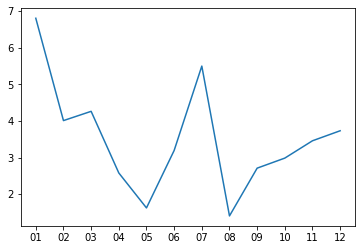

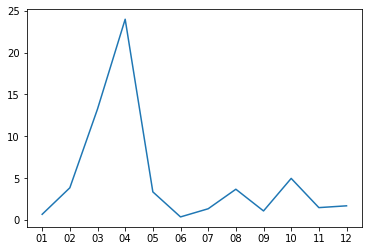

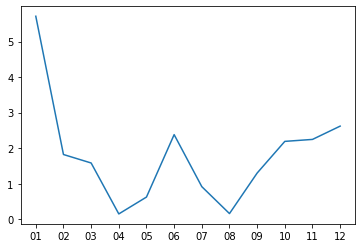

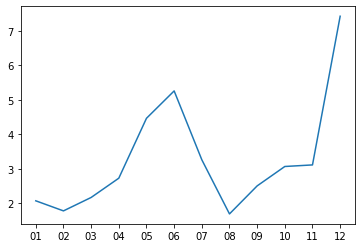

In [10]:


annee = 2018
while annee < 2023 :
    
    mois = []
    retards_moyens_du_mois = []

    for index, row in paris_stras.iterrows():
        
        if int(row['date'][:4]) == annee:
             
            mois.append(row['date'][5:])
            retards_moyens_du_mois.append(row['retard_moyen_tous_trains_arrivee'])
           
    annee+=1

    plt.plot(mois, retards_moyens_du_mois)

    plt.show()

On remarque qu'il y a souvent un pic dans les mois d'été et un pic vers la fin d'année. On va donc garder l'information du mois pour rendre la donnée 'date' utile pour notre modèle. Sinon on aurait des valeurs isolées et ce ne serait pas très intéressant. Les changements entre les années sont du à des évènements inanticipables comme des tempètes par exemple. 

Informations reçues en TD, on peut aller chercher des données externes. Par exemple des infos sur les voies, sur les gares, sur les grèves... 


L'objectif est de pouvoir prévoir le temps de retard prévu pour les trains en retard au départ. Un train est en retard au départ, on connait son retard au départ
et on veut pouvoir dire aux utilisateurs à combien de retard ils peuvent s'attendre à l'arrivée pour qu'ils s'organisent en conséquence. Cela permet
aussi d'anticiper les correspondances. 
On va tester différents modèles. On retient donc pour features : mois, service, gare départ, gare arrivée, duree du trajet, nb trains prévus, nb_trains_retards, retards_moyen_départ. 
On se permet de prendre le nombre de trains en retard sur le mois la moyenne de retards parce qu'on pourrait imaginer qu'on ait les données depuis
le début du mois et qu'on puisse avec un autre modèle anticiper le nombre de retard en fin du mois et utiliser cette donnée dans notre modèle. 
On cherche à prédire retards_moyen. Un train qui part en retard à énormément de chances d'être en retard à l'arrivée. 

Suite au premiers tests, on ajoute la feature commentaire sur les retards dans le dataset d'entrée Cela permet d'anticiper des évènements excepionnels qui vont fortement influencer les temps moyens de retards des trains sur une ligne. 

In [107]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder



#On commence par transformer les dates en ne retenant que l'information du mois
data = pd.read_csv('../dataset/regularite-mensuelle-tgv-aqst.csv')
df = pd.DataFrame(data)






#On transforme la colonne commentaire, si un commentaire est présent, on met un 1, sinon un 0. 
def comm(com):
    if pd.isna(com): 
        return 0
    else :
        return 1
    
#On fait la transformation
df.loc[:, 'commentaires_retard_arrivee'] = df['commentaires_retard_arrivee'].apply(comm)

df_pre = df[df['date']<= '2022-12' ]
df_post = df[df['date']>= '2023-01' ]

def mois(date):
    mois = date[5:]
    return mois 
    
#On fait la transformation
df_pre.loc[:, 'date'] = df_pre['date'].apply(mois)
df_post.loc[:, 'date'] = df_post['date'].apply(mois)


#On crée un dataset X avec les informations qui nous intéressent, à savoir : mois, service, gare départ, 
# gare arrivée, duree du trajet, nb trains prévus, nb_trains_retards_départ, retards_moyen_départ

X_pre = df_pre[['date','service', 'gare_depart', 'gare_arrivee', 'duree_moyenne', 'nb_train_prevu','nb_train_depart_retard', 'retard_moyen_depart', 'commentaires_retard_arrivee']]
X_post = df_post[['date','service', 'gare_depart', 'gare_arrivee', 'duree_moyenne', 'nb_train_prevu','nb_train_depart_retard', 'retard_moyen_depart', 'commentaires_retard_arrivee']]


#On crée le dataset y avec la colonne à estimer. On prendra retard_moyen_arrivee.

y_train = df_pre[['retard_moyen_arrivee']]
y_test = df_post[['retard_moyen_arrivee']]




c:\Users\arnoh\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [108]:
#On commence par le one hot encoding des mois, des gares d'arrivée et de départ. 
categorical_features = ["date","gare_depart", "gare_arrivee", "service"]

#Les valeurs numériques 
numeric_features = list(X_pre.drop(["date","gare_depart", "gare_arrivee", "service"], axis=1))


pipeline_traitement_données = ColumnTransformer([
     ('std_scaler', StandardScaler(), numeric_features),
     ('one-hot', OneHotEncoder(), categorical_features)
])

X_transformed_train = pipeline_traitement_données.fit_transform(X_pre)

X_train_array = X_transformed_train.toarray()

column_names_train = pipeline_traitement_données.get_feature_names_out(input_features=X_pre.columns)


# Recreate a DataFrame with column names and values
X_final_train = pd.DataFrame(X_train_array, columns=column_names_train)

X_transformed_test = pipeline_traitement_données.fit_transform(X_post)

X_test_array = X_transformed_test.toarray()

column_names_test = pipeline_traitement_données.get_feature_names_out(input_features=X_post.columns)

# Recreate a DataFrame with column names and values
X_final_test = pd.DataFrame(X_test_array, columns=column_names_test)

diff = X_final_train.columns.difference(X_final_test.columns)

for col in diff:
    X_final_test[col] = 0

X_final_test= X_final_test[X_final_train.columns]







In [109]:
a = X_final_train.copy()
a = a.assign(**y_train)
correlation_matrix = a.corrwith(a['retard_moyen_arrivee'])

print(correlation_matrix)

# y_train = y_train.values.ravel()
# y_test = y_test.values.ravel()

std_scaler__duree_moyenne                  0.420817
std_scaler__nb_train_prevu                -0.075444
std_scaler__nb_train_depart_retard        -0.085110
std_scaler__retard_moyen_depart            0.180001
std_scaler__commentaires_retard_arrivee    0.174085
                                             ...   
one-hot__gare_arrivee_VANNES              -0.011403
one-hot__gare_arrivee_ZURICH               0.028492
one-hot__service_International             0.083502
one-hot__service_National                 -0.083502
retard_moyen_arrivee                       1.000000
Length: 138, dtype: float64


In [112]:

#On teste plusieurs modèle et on sort une matrice avec les erreurs moyennes sur la cross validation 


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Définir une liste de modèles de régression à tester
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('ElasticNet', ElasticNet()),
    ('Decision Tree', DecisionTreeRegressor()),
    ('Random Forest', RandomForestRegressor()),
    ('SVR', SVR()),
    ('K-Nearest Neighbors', KNeighborsRegressor())
]


# Créer une matrice pour stocker les erreurs de chaque modèle
results = []

# Définissez une liste de métriques à utiliser
scoring = ['neg_mean_squared_error', 'r2']

# Effectuer la validation croisée pour chaque modèle
for i, (name, model) in enumerate(models):
    # Calculer les erreurs en utilisant la validation croisée
    scores = cross_validate(model, X_final_train, y_train, cv=5, scoring = scoring)
    
    # Calculer la racine carrée de l'erreur quadratique moyenne (RMSE)
    rmse_norm_scores = np.sqrt(-scores['test_neg_mean_squared_error'])
    
    
    # Stocker le nom du modèle et la moyenne des RMSE
    results.append((name, rmse_norm_scores.mean()/(y_train['retard_moyen_arrivee'].max()-y_train['retard_moyen_arrivee'].min()), scores['test_r2'].mean()))





c:\Users\arnoh\anaconda3\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\arnoh\anaconda3\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\arnoh\anaconda3\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\arnoh\anaconda3\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

In [114]:
# Créer un DataFrame pour afficher les résultats
results_df = pd.DataFrame(results, columns=['Modèle', 'RMSE moyen', 'r2'])
print(results_df)

                Modèle  RMSE moyen        r2
0    Linear Regression    0.047852  0.113391
1                Ridge    0.047187  0.137210
2                Lasso    0.046837  0.147248
3           ElasticNet    0.046901  0.146523
4        Decision Tree    0.058055 -0.334481
5        Random Forest    0.043614  0.261223
6                  SVR    0.043169  0.276795
7  K-Nearest Neighbors    0.046467  0.158870


Random forest et SVR marchent le mieux avec 13 minutes d'erreur moyenne sur les retards environ.  

En faisant tourner le même code en utilisant R2 pour le scoring, on se rend compte qu'on est pas bien meilleur que l'estimateur qui prédit la moyenne des retards pour chaque élément, on a encore du travail à faire...

Voyons si on peut améliorer cela. On pourrait commencer en ajoutant le feature secteur ou plutot LGV. Comme l'étude plus haut le montre, les lignes enmpruntant la même LGV seront souvent affectées ensemble.

Nouvelle idée, pour chaque cellule ou il ya un commentaire sur les raisons du retard, on sait qu'il y a un événement spécial qui se produit qui risque de fortement augmenter les retards. Cela crée des outliers qui baissent les performances de la regression. On pourrait faire un one-hot-encoding sur le présence ou non d'un commentaire, qui signifierait qu'il y a un évènement particulier à prendre en considération pour anticiper les retards. Les évènements sont généralement anticipables ou connus avant qu'un train ne circule. 

Update : cela ne marche pas super bien, on peut essayer en supprimant les lignes ou il y un commentaire car les retards de ces lignes sont dus à des évènement exceptionnels et imprévisibles. On ne prédit que dans un cas "classique"

In [73]:
#fit SVR sur le train set  complet et test sur l'année 2023
regr = SVR()

# Entraîner le modèle sur l'ensemble d'entraînement
regr.fit(X_final_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = regr.predict(X_final_test)

# Calculer le RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(rmse)



18.415008346922146


In [104]:
#On supprime les lignes avec des commentaires non nuls.


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder



#On commence par transformer les dates en ne retenant que l'information du mois
data = pd.read_csv('../dataset/regularite-mensuelle-tgv-aqst.csv')
df = pd.DataFrame(data)






df = df[df['commentaires_retard_arrivee'].isna()]

df_pre = df[df['date']<= '2022-12' ]
df_post = df[df['date']>= '2023-01' ]

def mois(date):
    mois = date[5:]
    return mois 
    
#On fait la transformation
df_pre.loc[:, 'date'] = df_pre['date'].apply(mois)
df_post.loc[:, 'date'] = df_post['date'].apply(mois)


#On crée un dataset X avec les informations qui nous intéressent, à savoir : mois, service, gare départ, 
# gare arrivée, duree du trajet, nb trains prévus, nb_trains_retards_départ, retards_moyen_départ

X_pre = df_pre[['date','service', 'gare_depart', 'gare_arrivee', 'duree_moyenne', 'nb_train_prevu','nb_train_depart_retard', 'retard_moyen_depart']]
X_post = df_post[['date','service', 'gare_depart', 'gare_arrivee', 'duree_moyenne', 'nb_train_prevu','nb_train_depart_retard', 'retard_moyen_depart']]


#On crée le dataset y avec la colonne à estimer. On prendra retard_moyen_arrivee.

y_train = df_pre[['retard_moyen_arrivee']]
y_test = df_post[['retard_moyen_arrivee']]





c:\Users\arnoh\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [105]:
#On commence par le one hot encoding des mois, des gares d'arrivée et de départ. 
categorical_features = ["date","gare_depart", "gare_arrivee", "service"]

#Les valeurs numériques 
numeric_features = list(X_pre.drop(["date","gare_depart", "gare_arrivee", "service"], axis=1))


pipeline_traitement_données = ColumnTransformer([
     ('std_scaler', StandardScaler(), numeric_features),
     ('one-hot', OneHotEncoder(), categorical_features)
])

X_transformed_train = pipeline_traitement_données.fit_transform(X_pre)

X_train_array = X_transformed_train.toarray()

column_names_train = pipeline_traitement_données.get_feature_names_out(input_features=X_pre.columns)


# Recreate a DataFrame with column names and values
X_final_train = pd.DataFrame(X_train_array, columns=column_names_train)

X_transformed_test = pipeline_traitement_données.fit_transform(X_post)

X_test_array = X_transformed_test.toarray()

column_names_test = pipeline_traitement_données.get_feature_names_out(input_features=X_post.columns)

# Recreate a DataFrame with column names and values
X_final_test = pd.DataFrame(X_test_array, columns=column_names_test)

diff = X_final_train.columns.difference(X_final_test.columns)

for col in diff:
    X_final_test[col] = 0

X_final_test= X_final_test[X_final_train.columns]

In [106]:
regr = SVR()

# Entraîner le modèle sur l'ensemble d'entraînement
regr.fit(X_final_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = regr.predict(X_final_test)

# Calculer le RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(rmse)

c:\Users\arnoh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


18.889793940256528


Cela ne marche pas mieux en supprimant les lignes avec commentaire. 